# Import Libraries/Data


In [1]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Regression Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## Classification Models & evaluation metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance

## saving variables for next lesson/notebook
import joblib

# especially used when coverting log odds to regular odds
import math

import shap
from lime.lime_tabular import LimeTabularExplainer

import os

## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## set pandas to display more columns
pd.set_option('display.max_columns',50)
import datetime as dt

#import tick customization tools
import matplotlib.ticker as mticks
import matplotlib.dates as mdates


import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use(['fivethirtyeight'])#'seaborn-talk'])#,
plt.rcParams['figure.facecolor']='white'

In [3]:
loaded = joblib.load('Data/saved_model.joblib')
loaded.keys()

dict_keys(['preprocessor', 'X_train', 'X_test', 'y_train', 'y_test', 'LinearRegression', 'RandomForestRegressor'])

In [4]:
preprocessor = loaded['preprocessor']
X_train = loaded['X_train']
X_test = loaded['X_test']
y_train = loaded['y_train']
y_test = loaded['y_test']
lin_reg = loaded['LinearRegression']
rf_reg = loaded['RandomForestRegressor']

# Custom Functions

## Linear Regression

In [5]:
def plot_coeffs(coeffs, top_n=None, figsize=(4,5), 
                intercept=False, intercept_name="intercept", 
                annotate=False, ha='left', va='center', size=12, 
                xytext=(4,0), textcoords='offset points', color='tab:blue'):
    """ Plots the top_n coefficients from a Series, with optional annotations.
    """
    # Drop intercept if intercept=False and 
    if (intercept == False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n == None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        
        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize, color=color)
    ax.set(xlabel='Coefficient', 
            ylabel='Feature Names', 
            title=title)
    ax.axvline(0, color='k')    

    
    if annotate == True:
            for bar in ax.patches:
                ## calculate center of bar
                bar_ax = bar.get_y() + bar.get_height() / 2
                ## get the value to annotate
                val = bar.get_width()

                # handle negative values by setting them to position 0
                if val < 0:
                    val_pos = 0
                else:
                    val_pos = val        
        
                # ha and va stand for the horizontal and vertical alignment
                ax.annotate(f"{val:.3f}", (val_pos,bar_ax),
                            ha=ha, va=va, size=size,
                            xytext=xytext, textcoords=textcoords)
    return ax

In [6]:
def evaluate_regression(model, X_train=X_train,y_train=y_train, X_test=X_test, y_test=y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

# Random Forest Regression


In [7]:
def evaluate_classification(model, X_train=X_train, y_train=y_train,
                            X_test=X_test, y_test=y_test,
                            normalize='true',cmap='Blues', figsize=(10,5)):
    header="\tCLASSIFICATION REPORT"
    dashes='--'*40
    print(f"{dashes}\n{header}\n{dashes}")
    ## training data
    print('[i] Training Data:')
    y_pred_train = model.predict(X_train)
    report_train = metrics.classification_report(y_train, y_pred_train)
    print(report_train)
    fig,ax = plt.subplots(figsize=figsize,ncols=2)
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_train,y_train,
                                                  normalize=normalize,
                                                   cmap=cmap,ax=ax[0])
    metrics.RocCurveDisplay.from_estimator(model,X_train,y_train,ax=ax[1])
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].grid()
    
    fig.tight_layout()
    plt.show()
     
    print(dashes)
    ## test data
    print(f"[i] Test Data:")
    y_pred_test = model.predict(X_test)
    report_test = metrics.classification_report(y_test, y_pred_test)
    print(report_test)
    fig,ax = plt.subplots(figsize=figsize,ncols=2)
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_test,y_test,
                                                  normalize=normalize,
                                                   cmap=cmap, ax=ax[0])
    metrics.RocCurveDisplay.from_estimator(model,X_test,y_test,ax=ax[1])
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].grid()
    fig.tight_layout()
    plt.show()

In [8]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True, permutation=False, random_state=SEED,
                   X_train=X_train, y_train=y_train, n_jobs=None):

    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    if permutation==False:
        importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
        
    if permutation==True:
        r = permutation_importance(model, X_train, y_train, n_repeats =5, 
                                   random_state = random_state, n_jobs=n_jobs)
        
        importances = pd.Series(r['importances_mean'],index=X_train.columns,
                           name = 'permutation importance')
    
        # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances

In [9]:
def get_color_dict(importances, color_rest='#006ba4' , color_top='green',
                    top_n=7):
    ## color -coding top 5 bars
    highlight_feats = importances.sort_values(ascending=True).tail(top_n).index
    colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}
    return colors_dict

In [10]:
def plot_importance_color(importances, top_n=None,  figsize=(8,6), 
                          color_dict=None, color_rest='#006ba4', color_top='green',
                          top_important=5, ax=None):
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors, ax=ax)
        
    else:
        highlight_feats = importances.sort_values(ascending=True).tail(top_important).index
        colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}        
        colors = plot_vals.index.map(colors_dict)
        
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors, ax=ax)
        
    # set titles and axis labels
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax

# Process Data

In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2197 entries, 853 to 2586
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Lot Area       2197 non-null   int64  
 1   Lot Frontage   1825 non-null   float64
 2   Overall Cond   2197 non-null   int64  
 3   Total Bsmt SF  2196 non-null   float64
 4   Central Air    2197 non-null   object 
 5   Gr Liv Area    2197 non-null   int64  
 6   TotRms AbvGrd  2197 non-null   int64  
 7   Land Contour   2197 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 154.5+ KB


In [12]:
y_train.head()

853     140000
1055    372402
2483    107000
2351    179900
1700    418000
Name: SalePrice, dtype: int64

In [13]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['Lot Area', 'Lot Frontage', 'Overall Cond', 'Total Bsmt SF',
       'Gr Liv Area', 'TotRms AbvGrd', 'Central Air_Y',
       'Land Contour_Bnk', 'Land Contour_HLS', 'Land Contour_Low',
       'Land Contour_Lvl'], dtype=object)

In [14]:
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_train_df.head(3)

,Lot Area,Lot Frontage,Overall Cond,Total Bsmt SF,Gr Liv Area,TotRms AbvGrd,Central Air_Y,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl
853,16269.0,69.230685,5.0,907.0,907.0,5.0,1.0,0.0,0.0,0.0,1.0
1055,13891.0,107.000000,5.0,1710.0,1710.0,6.0,1.0,0.0,0.0,0.0,1.0
2483,8900.0,69.230685,4.0,1056.0,1056.0,5.0,1.0,0.0,0.0,0.0,1.0


In [15]:
y_train.head(3)

853     140000
1055    372402
2483    107000
Name: SalePrice, dtype: int64

In [16]:
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_df.head(3)

,Lot Area,Lot Frontage,Overall Cond,Total Bsmt SF,Gr Liv Area,TotRms AbvGrd,Central Air_Y,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl
343,13860.0,75.0,7.0,1952.0,2704.0,9.0,1.0,0.0,0.0,0.0,1.0
1413,8405.0,50.0,8.0,861.0,1367.0,7.0,1.0,0.0,0.0,0.0,1.0
2583,11310.0,75.0,5.0,1367.0,1375.0,5.0,1.0,0.0,0.0,0.0,1.0


In [17]:
y_test.head(3)

343     345000
1413    119000
2583    140000
Name: SalePrice, dtype: int64

# Explain Linear Regression Model


- Extract the coefficients and save them as a Series with the correct feature names as the index.
- Change the pandas option for float format to display the coefficients with pandas in a readable form:
  - separator for thousands
  - 2 decimal places.
- Create a bar graph of the coefficients, sorted from largest to smallest.
- Provide a quantitative interpretation (both magnitude and directionality) of the three largest positive coefficients explaining how that feature impacts the target.
- Provide a quantitative interpretation (both magnitude and directionality) of the three largest negative coefficients explaining how that feature impacts the target.

## Save Coefficients as Pandas Series

In [18]:
lin_reg.coef_

array([ 1.07876315e-01,  1.09311338e+02,  1.73731332e+03,  5.97539756e+01,
        1.01283754e+02, -6.29990698e+03,  3.19272244e+04, -7.26204665e+04,
        4.24362731e+03, -4.33109607e+04, -4.22641863e+04])

In [19]:
## Saving the coefficients
coeffs = pd.Series(lin_reg.coef_, index= feature_names)
coeffs

Lot Area                0.107876
Lot Frontage          109.311338
Overall Cond         1737.313325
Total Bsmt SF          59.753976
Gr Liv Area           101.283754
TotRms AbvGrd       -6299.906977
Central Air_Y       31927.224382
Land Contour_Bnk   -72620.466486
Land Contour_HLS     4243.627305
Land Contour_Low   -43310.960673
Land Contour_Lvl   -42264.186316
dtype: float64

In [20]:
print(len(coeffs))
len(feature_names)

11


11

## Format Number Display


In [21]:
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")
coeffs

Lot Area                 0.11
Lot Frontage           109.31
Overall Cond         1,737.31
Total Bsmt SF           59.75
Gr Liv Area            101.28
TotRms AbvGrd       -6,299.91
Central Air_Y       31,927.22
Land Contour_Bnk   -72,620.47
Land Contour_HLS     4,243.63
Land Contour_Low   -43,310.96
Land Contour_Lvl   -42,264.19
dtype: float64

## Coefficient Visualization Bar Graph

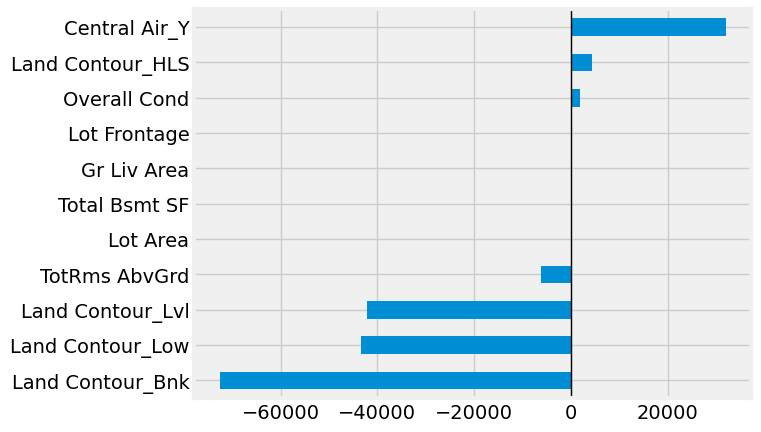

In [22]:
ax = coeffs.sort_values().plot(kind='barh')
ax.axvline(0, color='k', lw=1);

## Largest Coefficients 3 Positive and 3 Negative and Impact Explanation


Training Data:	R^2= 0.66	RMSE= 47743.32
Test Data:	R^2= 0.66	RMSE= 42544.20


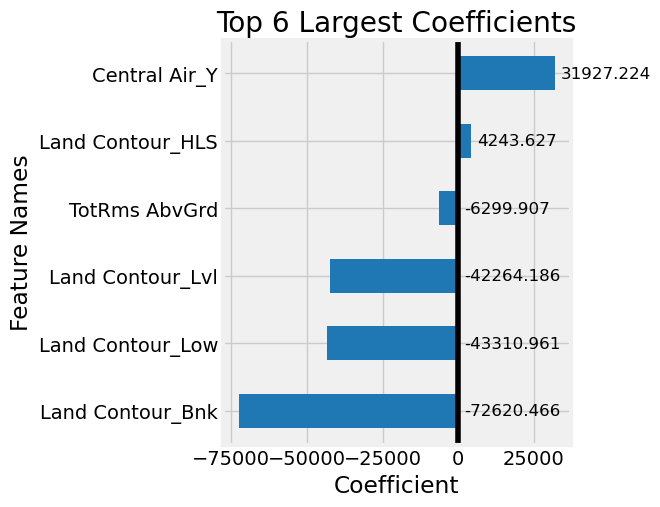

In [23]:
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)
plot_coeffs(coeffs,top_n=6,annotate=True, color='tab:blue');

### Top 2 Positive Coefficients

- "Central Air_Y" (Central Air)
   - If this is true, increases price by $32,000.
   

- "Land Countour_HLS" (Land Contour)
   - If this is true, increase price by $4,244.
   

### Top 4 Negative Coefficients

- "TotRms AbvGrd (Total Rooms Above Ground)
   - If true, decreases price by $6,300.
   

- Land Countour_Lvl (Land Contour Level)
  - If true, decreases price by $42,264.
  
  
- Land Countour_Low (Land Contour Low)
  - If true, decreases price by $43,311.
  
  
- Land Contour_Bnk (Land Contour Bank)
  - If true, decreases price by $72,620.

   
 

# Explain the Random Forest Model

- Extract and create a bar graph of the feature importances, sorted from largest to smallest.
- What are the top 6 most important features?
- Of the top 6 most important features, identify which of these features also appeared in the 3 largest or 3 smallest coefficients.

In [24]:
evaluate_regression(rf_reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.97	RMSE= 14817.31
Test Data:	R^2= 0.77	RMSE= 35317.36


In [25]:
importances = get_importances(rf_reg)
importances

Lot Area           0.06
Lot Frontage       0.05
Overall Cond       0.03
Total Bsmt SF      0.36
Gr Liv Area        0.44
TotRms AbvGrd      0.03
Central Air_Y      0.01
Land Contour_Bnk   0.01
Land Contour_HLS   0.01
Land Contour_Low   0.00
Land Contour_Lvl   0.00
Name: Feature Importance, dtype: float64

In [26]:
color_dict = get_color_dict(importances, top_n=6)

## Feature Importances Bar Graph

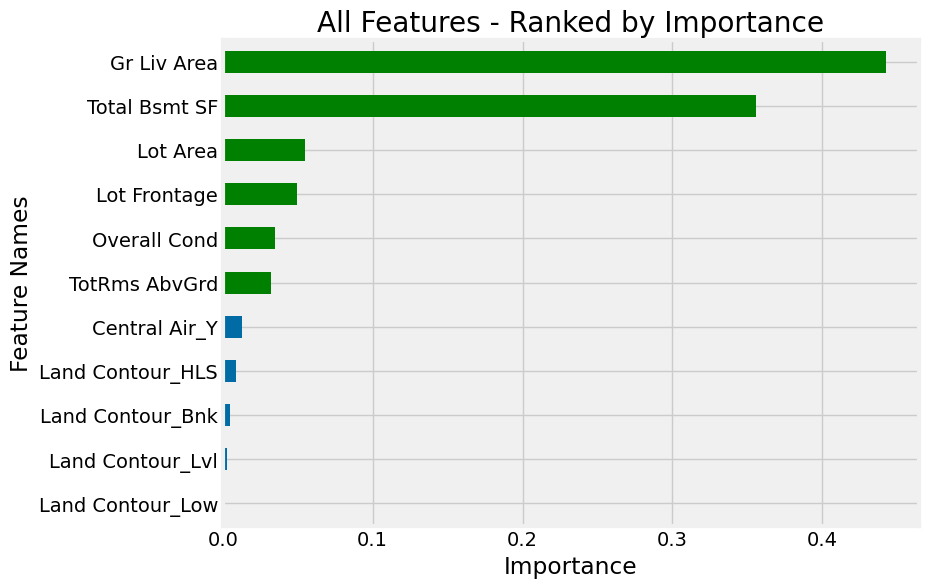

In [27]:
plot_importance_color(importances, figsize=(8,6), color_dict=color_dict);

### Top 6 Most Important Features

- "Gr Liv Area"
- "Total Bsmt SF"
- "Lot Area"
- "Lot Frontage"
- "Overall Cond"
- "TotRms AbvGrd"

### Comparing with Top 6 Coefficients

These features appear in the top 6 for both Coefficients and Feature Importance:

- Lot Area
- Overall Cond
- TotRms AbvGrd

## Apply SHAP to Explain the Random Forest Model

- Sample 500 rows of the processed X_train data as X_shap, using random_state=321
- Save the corresponding y_train values as y_shap
- Create a shap model explainer for the random forest model
- Calculate the shap values for the sampled data
- Create a summary plot (plot_type =’dot’) of the most important features, according to shap.
- Interpret the top 6 most important features. According to shap, what effect does each feature have on the model’s prediction?

In [28]:
shap.initjs()

## Sample SHAP

- Learning Platform instruction is for 500 samples 
- Will sample 100 with random_state=321

In [29]:
len(X_train_df)

2197

In [30]:
X_shap = shap.sample(X_train_df,nsamples=100,random_state=321)
X_shap.head()

,Lot Area,Lot Frontage,Overall Cond,Total Bsmt SF,Gr Liv Area,TotRms AbvGrd,Central Air_Y,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl
297,"19,645.00",85.00,6.00,423.00,"1,652.00",6.00,1.00,0.00,0.00,0.00,1.00
2846,"8,400.00",60.00,5.00,940.00,"1,595.00",6.00,1.00,1.00,0.00,0.00,0.00
1319,"5,700.00",69.23,7.00,572.00,"1,111.00",5.00,1.00,0.00,0.00,0.00,1.00
1570,"164,660.00",69.23,6.00,"1,499.00","1,786.00",7.00,1.00,0.00,1.00,0.00,0.00
1139,"8,453.00",65.00,5.00,754.00,"1,609.00",6.00,1.00,0.00,0.00,0.00,1.00


In [31]:
len(X_shap)

100

In [32]:
## get the corresponding y-values
y_shap = y_train.loc[X_shap.index]
y_shap

297     203135
2846    140000
1319    116900
1570    228950
1139    182000
         ...  
2626     93500
1139    182000
814     113722
1105    350000
548     145000
Name: SalePrice, Length: 100, dtype: int64

## SHAP Model Explainer

In [33]:
explainer = shap.Explainer(rf_reg)
explainer

In [34]:
## Getting the shap values
shap_values = explainer(X_shap,y_shap)
type(shap_values)

shap._explanation.Explanation

In [35]:
shap_values.shape

(100, 11)

## SHAP Summary Plot Dot

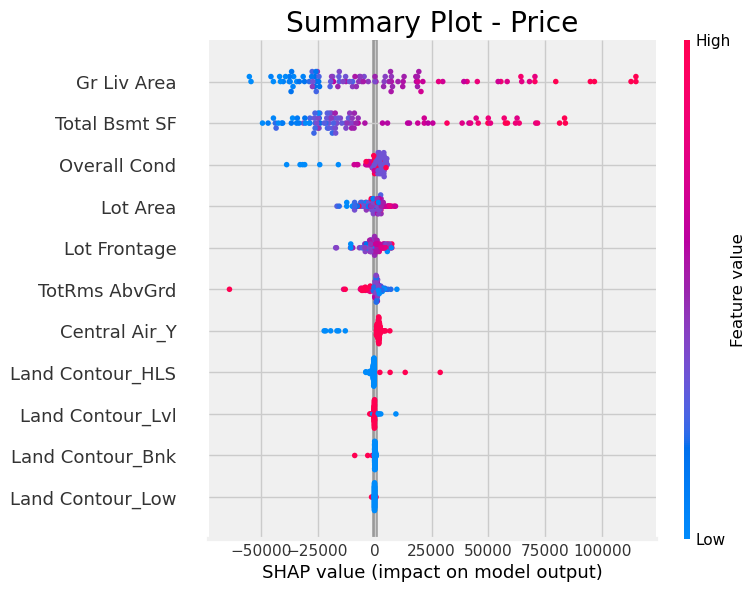

In [36]:
fig, ax = plt.subplots()
shap.summary_plot(shap_values, features= X_shap, show=False)
ax.set_title('Summary Plot - Price');

### Interpretation of Top 6 Features

- "Gr Liv Area"

  - Higher sq footage(red), higher the cost
  
  
- "Total Bsmt SF"

  - Higher basement sq footage(red), higher the cost
  
  
- "Overall Cond"

  - The poorer (blue) the condition can significantly decrease the cost
  

- "Lot Area"

  - The poorer (blue) the condition the decreased cost 
  

- "Lot Frontage"

  - The smaller the front of the yard (blue) slightly decreases the cost 
  

- "TotRms AbvGrd"

  - Minimal rooms above ground will sharply decrease the cost (blue)
  
   

# Part 2

- Load the provided csv, located in the zip file you downloaded in Part 1.
- Prepare the data as a time series DataFrame:
- Melt the wide-form data into a long-form time series.
- The date column should be named “Date”
- The value column should be named “Home Value”
- Convert the Date column to Datetime data type.
- Set the Date column as the index


- Filter the data:


- Keep data from the following states:  CA, WA, OR, AZ, NV
- Keep values from the years  2010 - 2020.
- Save the processed data as a  .csv file in a “Data” folder inside your private repo, name the csv - “Data/data-for-tableau.csv”
- Resample the home values, grouped by states, to a yearly frequency (based on the beginning of the calendar year) using the mean as the aggregation function.
- Plot a line graph with each of the states as a separate line.

In [37]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

#import tick customization tools
import matplotlib.ticker as mticks
import matplotlib.dates as mdates

# list of named time zones
import pytz
#all_tzs = pytz.all_timezones
#len(all_tzs)

# import the statsmodels time series analysis api module
# seasonal decompose
import statsmodels.tsa.api as tsa

# get peaks (max point) of each season
from scipy.signal import find_peaks

import holidays
import datetime as dt
from holidays import country_holidays


import warnings
warnings.filterwarnings('ignore')

# Custom Functions

In [38]:
def format_xdates(ax, fig=None, xtick_fontweight='bold',
               title= None):
    """Formats x-axis with minor ticks every 3 months, and major 
    ticks every year. Includes different grid options for visibility"""
    # create the locator to place ticks every 3 months.
    loc_3months = mdates.MonthLocator(interval=3)
    fmt_months = mdates.DateFormatter("%b")
    ## for major year ticks
    loc_year = mdates.YearLocator()
    fmt_year = mdates.DateFormatter("%Y")
    
    ## Change the font of the major ticks to stand out
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), 
                       fontweight=xtick_fontweight) 
    
    ## customize minor ticks
    ax.xaxis.set_minor_locator(loc_3months)
    ax.xaxis.set_minor_formatter(fmt_months)
    ## customize major ticks
    ax.xaxis.set_major_locator(loc_year)
    ax.xaxis.set_major_formatter(fmt_year)
    ## Making major/minor gridlines visually distince
    ax.grid(which='minor',axis='x',ls=":")
    ax.grid(which='major',axis='x',color='k')
    if fig is None:
        fig = ax.get_figure()
    ## rotate the dates
    fig.autofmt_xdate(which='major',rotation=90,ha='center')
    return fig,ax

In [39]:
def millions(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000_000
    return f"{new_x:,.0f}M"
def thousands(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000
    return f"{new_x:,.0f}K"
# Create the formatters
fmt_mill = mticks.FuncFormatter(millions)
fmt_thous = mticks.FuncFormatter(thousands)

#ax1.yaxis.set_major_formatter(fmt_mill)
#ax2.yaxis.set_major_formatter(fmt_thous)

In [40]:
df = pd.read_csv('Data/zillow_home_values-zipcode.csv')
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,31012000,29022000,31032000,30042000,31052000,30062000,31072000,31082000,30092000,31102000,30112000,31122000,31012001,28022001,31032001,30042001,...,30112020,31122020,31012021,28022021,31032021,30042021,31052021,30062021,31072021,31082021,30092021,31102021,30112021,31122021,31012022,28022022,31032022,30042022,31052022,30062022,31072022,31082022,30092022,31102022,30112022
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,"107,261.00","107,274.00","107,076.00","107,081.00","107,112.00","107,325.00","107,480.00","107,709.00","108,092.00","108,328.00","108,782.00","109,187.00","109,242.00","109,045.00","108,514.00","108,330.00",...,"204,564.00","206,902.00","209,154.00","212,069.00","213,553.00","215,782.00","218,494.00","223,994.00","229,959.00","236,318.00","241,418.00","246,015.00","249,379.00","253,321.00","257,274.00","261,945.00","267,644.00","273,946.00","280,066.00","285,121.00","288,532.00","290,458.00","291,103.00","292,081.00","292,948.00"
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,"222,569.00","222,885.00","223,602.00","224,818.00","224,384.00","224,051.00","222,942.00","223,281.00","222,886.00","223,553.00","224,715.00","226,127.00","226,742.00","226,052.00","225,191.00","224,344.00",...,"346,146.00","350,598.00","354,599.00","359,133.00","364,502.00","370,992.00","377,896.00","386,576.00","397,227.00","408,018.00","417,061.00","424,951.00","431,973.00","437,659.00","443,701.00","453,150.00","464,727.00","478,369.00","489,712.00","497,173.00","499,429.00","497,572.00","498,113.00","500,187.00","503,109.00"
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,"90,009.00","90,009.00","90,042.00","90,007.00","90,027.00","89,987.00","89,972.00","89,926.00","89,397.00","88,767.00","87,904.00","87,765.00","87,719.00","87,845.00","87,409.00","87,119.00",...,"144,471.00","146,280.00","147,989.00","149,669.00","151,475.00","153,251.00","155,948.00","158,804.00","161,832.00","164,617.00","167,493.00","169,790.00","171,741.00","173,354.00","175,355.00","177,319.00","179,463.00","182,812.00","186,403.00","189,836.00","192,064.00","193,760.00","195,140.00","196,787.00","198,137.00"
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,"188,096.00","190,588.00","192,155.00","194,686.00","196,246.00","198,131.00","200,596.00","202,906.00","205,407.00","208,731.00","212,367.00","215,368.00","217,915.00","220,488.00","223,666.00","226,950.00",...,"583,072.00","582,981.00","580,157.00","578,240.00","577,104.00","577,493.00","579,678.00","579,581.00","579,996.00","579,154.00","580,023.00","578,203.00","576,272.00","572,245.00","570,414.00","570,211.00","572,145.00","573,662.00","576,469.00","578,706.00","580,834.00","581,779.00","584,566.00","588,188.00","590,722.00"
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,"275,983.00","277,855.00","279,802.00","282,271.00","283,679.00","284,880.00","285,975.00","288,330.00","290,339.00","293,681.00","296,592.00","299,017.00","300,344.00","302,885.00","307,212.00","311,950.00",...,"712,619.00","716,779.00","721,142.00","722,880.00","723,884.00","724,676.00","730,056.00","733,300.00","735,223.00","734,912.00","738,325.00","741,995.00","745,001.00","745,550.00","748,738.00","752,025.00","757,734.00","760,336.00","766,163.00","771,443.00","776,607.00","779,281.00","782,367.00","788,211.00","793,924.00"


# Melt DataFrame

In [41]:
df.columns[0:11]

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'City', 'Metro', 'CountyName', '31012000', '29022000'],
      dtype='object')

In [42]:
melted = pd.melt(df, id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 
                              'State', 'City', 'Metro', 
                              'CountyName',],
                 value_name='Confirmed', var_name='Date')
melted

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Date,Confirmed
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,31012000,"107,261.00"
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,31012000,"222,569.00"
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,31012000,"90,009.00"
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,31012000,"188,096.00"
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,31012000,"275,983.00"
...,...,...,...,...,...,...,...,...,...,...,...
7546545,80190,30657,50160,zip,IA,IA,Martensdale,"Des Moines-West Des Moines, IA",Warren County,30112022,"193,591.00"
7546546,65355,30657,18081,zip,PA,PA,Hellertown,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Bucks County,30112022,"376,523.00"
7546547,82217,30657,55366,zip,MN,MN,NaN,NaN,Sibley County,30112022,"110,082.00"
7546548,80581,30657,51009,zip,IA,IA,Calumet,NaN,O Brien County,30112022,"75,810.00"


# Format 'Date' to 'Datetime'

Looks like 'Date' is set as Day, Month, Year

In [43]:
fmt = '%d%m%Y'

melted['Datetime'] = pd.to_datetime(melted['Date'], format=fmt)
melted

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Date,Confirmed,Datetime
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,31012000,"107,261.00",2000-01-31
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,31012000,"222,569.00",2000-01-31
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,31012000,"90,009.00",2000-01-31
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,31012000,"188,096.00",2000-01-31
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,31012000,"275,983.00",2000-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...
7546545,80190,30657,50160,zip,IA,IA,Martensdale,"Des Moines-West Des Moines, IA",Warren County,30112022,"193,591.00",2022-11-30
7546546,65355,30657,18081,zip,PA,PA,Hellertown,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Bucks County,30112022,"376,523.00",2022-11-30
7546547,82217,30657,55366,zip,MN,MN,NaN,NaN,Sibley County,30112022,"110,082.00",2022-11-30
7546548,80581,30657,51009,zip,IA,IA,Calumet,NaN,O Brien County,30112022,"75,810.00",2022-11-30


# Set 'Datetime' as Index, Drop 'Date' & 'StateName'

In [44]:
melted = melted.set_index('Datetime')
melted.drop(columns='Date', inplace=True)
melted

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Confirmed
Datetime,,,,,,,,,,
2000-01-31,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,"107,261.00"
2000-01-31,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,"222,569.00"
2000-01-31,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,"90,009.00"
2000-01-31,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,"188,096.00"
2000-01-31,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,"275,983.00"
...,...,...,...,...,...,...,...,...,...,...
2022-11-30,80190,30657,50160,zip,IA,IA,Martensdale,"Des Moines-West Des Moines, IA",Warren County,"193,591.00"
2022-11-30,65355,30657,18081,zip,PA,PA,Hellertown,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Bucks County,"376,523.00"
2022-11-30,82217,30657,55366,zip,MN,MN,NaN,NaN,Sibley County,"110,082.00"


In [45]:
melted.drop(columns='StateName', inplace=True)
melted

,RegionID,SizeRank,RegionName,RegionType,State,City,Metro,CountyName,Confirmed
Datetime,,,,,,,,,
2000-01-31,91940,0,77449,zip,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,"107,261.00"
2000-01-31,91982,1,77494,zip,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,"222,569.00"
2000-01-31,93144,2,79936,zip,TX,El Paso,"El Paso, TX",El Paso County,"90,009.00"
2000-01-31,62080,3,11368,zip,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,"188,096.00"
2000-01-31,62093,4,11385,zip,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,"275,983.00"
...,...,...,...,...,...,...,...,...,...
2022-11-30,80190,30657,50160,zip,IA,Martensdale,"Des Moines-West Des Moines, IA",Warren County,"193,591.00"
2022-11-30,65355,30657,18081,zip,PA,Hellertown,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Bucks County,"376,523.00"
2022-11-30,82217,30657,55366,zip,MN,NaN,NaN,Sibley County,"110,082.00"


In [46]:
melted.index

DatetimeIndex(['2000-01-31', '2000-01-31', '2000-01-31', '2000-01-31',
               '2000-01-31', '2000-01-31', '2000-01-31', '2000-01-31',
               '2000-01-31', '2000-01-31',
               ...
               '2022-11-30', '2022-11-30', '2022-11-30', '2022-11-30',
               '2022-11-30', '2022-11-30', '2022-11-30', '2022-11-30',
               '2022-11-30', '2022-11-30'],
              dtype='datetime64[ns]', name='Datetime', length=7546550, freq=None)

# Filter Data

Filters

Keep States:

CA, WA, OR, AZ, NV

Keep Dates:

2010 - 2020

In [47]:
state_filter = melted['State'].isin(['CA', "WA", "OR", "AZ", "NV"])
state_filter

Datetime
2000-01-31    False
2000-01-31    False
2000-01-31    False
2000-01-31    False
2000-01-31    False
              ...  
2022-11-30    False
2022-11-30    False
2022-11-30    False
2022-11-30    False
2022-11-30    False
Name: State, Length: 7546550, dtype: bool

In [48]:
df_filtered = melted[state_filter]
df_filtered

,RegionID,SizeRank,RegionName,RegionType,State,City,Metro,CountyName,Confirmed
Datetime,,,,,,,,,
2000-01-31,95992,5,90011,zip,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,"143,426.00"
2000-01-31,96361,8,91331,zip,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,"144,841.00"
2000-01-31,96193,9,90650,zip,CA,Norwalk,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,"163,955.00"
2000-01-31,96083,12,90201,zip,CA,Bell,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,"163,273.00"
2000-01-31,96816,13,92335,zip,CA,Fontana,"Riverside-San Bernardino-Ontario, CA",San Bernardino County,"110,958.00"
...,...,...,...,...,...,...,...,...,...
2022-11-30,98502,30657,95950,zip,CA,Grimes,NaN,Colusa County,"313,005.00"
2022-11-30,95776,30657,89041,zip,NV,Pahrump,"Pahrump, NV",Nye County,"414,072.00"
2022-11-30,99923,30657,98623,zip,WA,White Salmon,NaN,Klickitat County,"729,920.00"


In [49]:

df_filtered = df_filtered.loc['2010':'2020']
df_filtered


,RegionID,SizeRank,RegionName,RegionType,State,City,Metro,CountyName,Confirmed
Datetime,,,,,,,,,
2010-01-31,95992,5,90011,zip,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,"209,250.00"
2010-01-31,96361,8,91331,zip,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,"257,372.00"
2010-01-31,96193,9,90650,zip,CA,Norwalk,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,"296,430.00"
2010-01-31,96083,12,90201,zip,CA,Bell,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,"271,829.00"
2010-01-31,96816,13,92335,zip,CA,Fontana,"Riverside-San Bernardino-Ontario, CA",San Bernardino County,"156,704.00"
...,...,...,...,...,...,...,...,...,...
2020-12-31,98502,30657,95950,zip,CA,Grimes,NaN,Colusa County,"220,881.00"
2020-12-31,95776,30657,89041,zip,NV,Pahrump,"Pahrump, NV",Nye County,NaN
2020-12-31,99923,30657,98623,zip,WA,White Salmon,NaN,Klickitat County,"538,209.00"


# Save the processed data 
as a  .csv file in a “Data” folder inside your private repo, name the csv “Data/data-for-tableau.csv”

In [50]:
df_filtered.to_csv('Data/data-for-tableau.csv')

- Resample the home values, grouped by states, to a yearly frequency (based on the beginning of the calendar year) using the mean as the aggregation function.
- Plot a line graph with each of the states as a separate line.

In [51]:
df_ts = df_filtered.groupby('State').resample('A').mean()
df_ts

RegionID  SizeRank  RegionName  Confirmed
State Datetime                                              
AZ    2010-12-31 125,430.67  9,836.64   85,550.34 169,930.89
      2011-12-31 125,430.67  9,836.64   85,550.34 152,272.47
      2012-12-31 125,430.67  9,836.64   85,550.34 159,902.06
      2013-12-31 125,430.67  9,836.64   85,550.34 183,657.23
      2014-12-31 125,430.67  9,836.64   85,550.34 198,551.49
      2015-12-31 125,430.67  9,836.64   85,550.34 206,834.17
      2016-12-31 125,430.67  9,836.64   85,550.34 217,452.80
      2017-12-31 125,430.67  9,836.64   85,550.34 229,066.03
      2018-12-31 125,430.67  9,836.64   85,550.34 244,689.17
      2019-12-31 125,430.67  9,836.64   85,550.34 257,396.58
      2020-12-31 125,430.67  9,836.64   85,550.34 278,841.94
CA    2010-12-31  98,747.74  9,324.49   93,598.65 415,491.81
      2011-12-31  98,747.74  9,324.49   93,598.65 388,468.03
      2012-12-31  98,747.74  9,324.49   93,598.65 388,593.63
      2013-12-31  98,747.74  9,324.49   93,598.65 454,509.85
      2014-12-31  98,747.74  9,324.49   93,598.65 505,808.42
      2015-12-31  98,747.74  9,324.49   93,598.65 535,297.12
      2016-12-31  98,747.74  9,324.49   93,598.65 569,319.27
      2017-12-31  98,747.74  9,324.49   93,598.65 601,938.43
      2018-12-31  98,747.74  9,324.49   93,598.65 646,936.55
      2019-12-31  98,747.74  9,324.49   93,598.65 649,531.48
      2020-12-31  98,747.74  9,324.49   93,598.65 675,124.17
NV    2010-12-31 112,977.66 10,727.58   89,265.24 189,285.32
      2011-12-31 112,977.66 10,727.58   89,265.24 168,931.54
      2012-12-31 112,977.66 10,727.58   89,265.24 165,003.29
      2013-12-31 112,977.66 10,727.58   89,265.24 199,847.53
      2014-12-31 112,977.66 10,727.58   89,265.24 228,975.14
      2015-12-31 112,977.66 10,727.58   89,265.24 247,372.12
      2016-12-31 112,977.66 10,727.58   89,265.24 265,123.98
      2017-12-31 112,977.66 10,727.58   89,265.24 284,543.22
      2018-12-31 112,977.66 10,727.58   89,265.24 319,753.46
      2019-12-31 112,977.66 10,727.58   89,265.24 337,914.43
      2020-12-31 112,977.66 10,727.58   89,265.24 350,564.89
OR    2010-12-31 106,076.82 14,728.10   97,394.49 224,035.02
      2011-12-31 106,076.82 14,728.10   97,394.49 205,273.04
      2012-12-31 106,076.82 14,728.10   97,394.49 201,899.02
      2013-12-31 106,076.82 14,728.10   97,394.49 216,964.50
      2014-12-31 106,076.82 14,728.10   97,394.49 233,022.53
      2015-12-31 106,076.82 14,728.10   97,394.49 249,633.92
      2016-12-31 106,076.82 14,728.10   97,394.49 272,424.45
      2017-12-31 106,076.82 14,728.10   97,394.49 294,524.76
      2018-12-31 106,076.82 14,728.10   97,394.49 311,491.06
      2019-12-31 106,076.82 14,728.10   97,394.49 323,800.94
      2020-12-31 106,076.82 14,728.10   97,394.49 338,782.97
WA    2010-12-31  99,857.94 13,383.39   98,603.70 250,932.49
      2011-12-31  99,857.94 13,383.39   98,603.70 230,557.03
      2012-12-31  99,857.94 13,383.39   98,603.70 225,432.14
      2013-12-31  99,857.94 13,383.39   98,603.70 240,848.44
      2014-12-31  99,857.94 13,383.39   98,603.70 256,869.92
      2015-12-31  99,857.94 13,383.39   98,603.70 275,704.94
      2016-12-31  99,857.94 13,383.39   98,603.70 302,116.53
      2017-12-31  99,857.94 13,383.39   98,603.70 334,494.27
      2018-12-31  99,857.94 13,383.39   98,603.70 367,370.46
      2019-12-31  99,857.94 13,383.39   98,603.70 381,711.64
      2020-12-31  99,857.94 13,383.39   98,603.70 408,430.21

# Unstack

In [52]:
unstacked = df_ts.unstack(level=0)
unstacked.head()

RegionID                                           SizeRank  \
State              AZ        CA         NV         OR        WA       AZ   
Datetime                                                                   
2010-12-31 125,430.67 98,747.74 112,977.66 106,076.82 99,857.94 9,836.64   
2011-12-31 125,430.67 98,747.74 112,977.66 106,076.82 99,857.94 9,836.64   
2012-12-31 125,430.67 98,747.74 112,977.66 106,076.82 99,857.94 9,836.64   
2013-12-31 125,430.67 98,747.74 112,977.66 106,076.82 99,857.94 9,836.64   
2014-12-31 125,430.67 98,747.74 112,977.66 106,076.82 99,857.94 9,836.64   

                                                  RegionName            \
State            CA        NV        OR        WA         AZ        CA   
Datetime                                                                 
2010-12-31 9,324.49 10,727.58 14,728.10 13,383.39  85,550.34 93,598.65   
2011-12-31 9,324.49 10,727.58 14,728.10 13,383.39  85,550.34 93,598.65   
2012-12-31 9,324.49 10,727.58 14,728.10 13,383.39  85,550.34 93,598.65   
2013-12-31 9,324.49 10,727.58 14,728.10 13,383.39  85,550.34 93,598.65   
2014-12-31 9,324.49 10,727.58 14,728.10 13,383.39  85,550.34 93,598.65   

                                          Confirmed                        \
State             NV        OR        WA         AZ         CA         NV   
Datetime                                                                    
2010-12-31 89,265.24 97,394.49 98,603.70 169,930.89 415,491.81 189,285.32   
2011-12-31 89,265.24 97,394.49 98,603.70 152,272.47 388,468.03 168,931.54   
2012-12-31 89,265.24 97,394.49 98,603.70 159,902.06 388,593.63 165,003.29   
2013-12-31 89,265.24 97,394.49 98,603.70 183,657.23 454,509.85 199,847.53   
2014-12-31 89,265.24 97,394.49 98,603.70 198,551.49 505,808.42 228,975.14   

                                  
State              OR         WA  
Datetime                          
2010-12-31 224,035.02 250,932.49  
2011-12-31 205,273.04 230,557.03  
2012-12-31 201,899.02 225,432.14  
2013-12-31 216,964.50 240,848.44  
2014-12-31 233,022.53 256,869.92

In [53]:
ts = unstacked['Confirmed']
ts.head(3)

State,AZ,CA,NV,OR,WA
Datetime,,,,,
2010-12-31,"169,930.89","415,491.81","189,285.32","224,035.02","250,932.49"
2011-12-31,"152,272.47","388,468.03","168,931.54","205,273.04","230,557.03"
2012-12-31,"159,902.06","388,593.63","165,003.29","201,899.02","225,432.14"


# Line Graph per State

In [61]:
#loc_3months = mdates.MonthLocator(interval=3)
# create the formatter to display 3-letter month names + 2-digit year
fmt_months = mdates.DateFormatter("%b")

## for major year ticks
#loc_year = mdates.YearLocator()
fmt_year = mdates.DateFormatter("%Y")

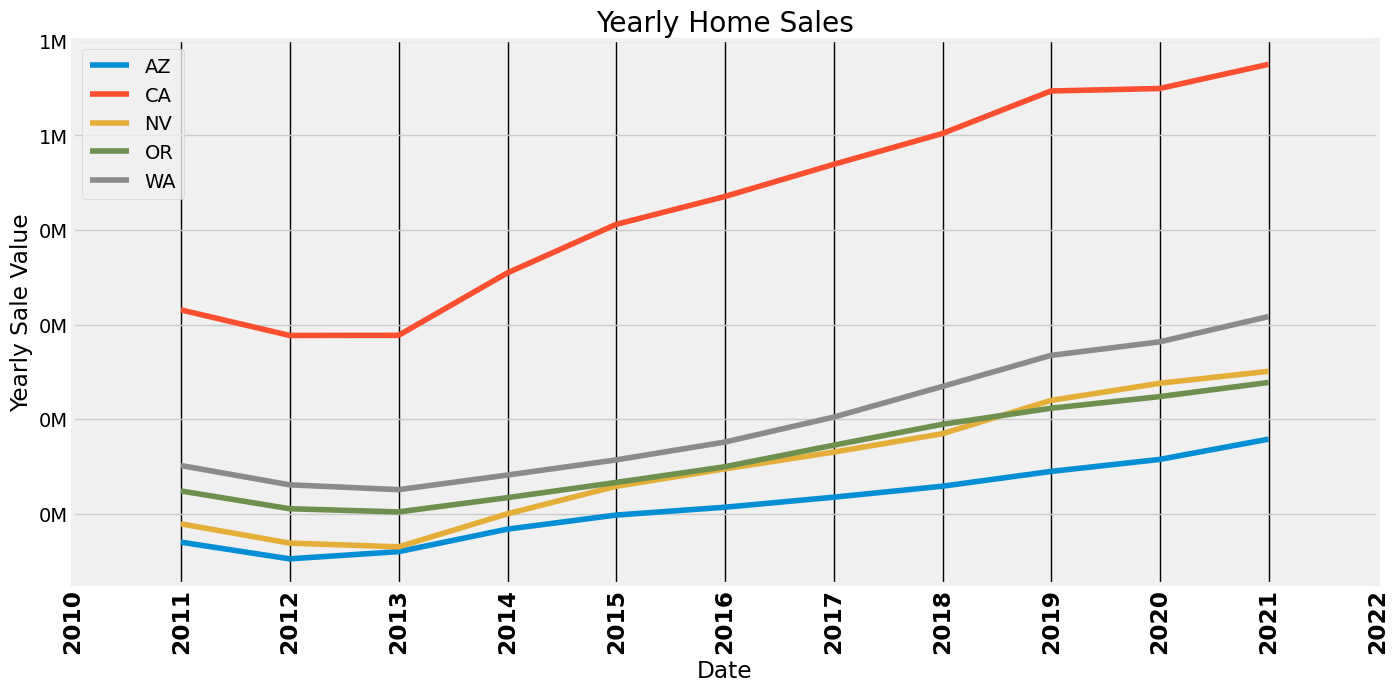

In [62]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(ts.index, ts.values)

ax.yaxis.set_major_formatter(fmt_mill) 

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), fontsize='large',fontweight='bold' ) 
##  customize minor ticks
#ax.xaxis.set_minor_locator(loc_3months)
ax.xaxis.set_minor_formatter(fmt_year)
##  customize major ticks
ax.xaxis.set_major_locator(loc_year)
ax.xaxis.set_major_formatter(fmt_year)
##  Making major/minor gridlines visually distince
ax.grid(which='minor',axis='x',ls=":")
ax.grid(which='major',axis='x',color='k')
fig.autofmt_xdate(rotation=90,ha='center')

plt.title('Yearly Home Sales')
plt.xlabel('Date')
plt.ylabel('Yearly Sale Value')
ax.legend(ts.columns);

# Tableau Link

https://public.tableau.com/app/profile/thomas.bingamon/viz/MedianHomeValues-BeltExamA/Story1?publish=yes